# Capture the turn over point

in this notebook, I will try to dev a code that could help me capture the turn_over point in the evolutionary tracks so that we could find where is the zero-age-main-sequence

In [1]:
import numpy as np
import pandas as pd

import os, sys, tqdm, copy

import tqdm
import tqdm.notebook

import matplotlib.pyplot as plt
import matplotlib

style = [
    # 'seaborn-ticks',
    {
        'figure.dpi': 300,
        'font.size': 12,
        'image.cmap': 'inferno',
        'font.family': 'serif',
        'font.serif': ['Times', 'Times New Roman'] + plt.rcParams['font.serif'],
        'xtick.top': True,
        'xtick.direction': 'in',
        'ytick.right': True,
        'ytick.direction': 'in',
        'mathtext.fontset': 'cm'
        }]
plt.style.use(style)

# import scipy.io

# github_dir = '/home/dingshandeng/github/ysoisochrone/'
github_dir = '/Users/dingshandeng/github/ysoisochrone/'

os.chdir(os.path.join(github_dir, 'tests'))
sys.path.append(os.path.join(github_dir))

# import ysoisochrone.utils as utils
# import ysoisochrone.bayesian as bayesian
# import ysoisochrone.plotting as plotting
import ysoisochrone

## We use Baraffe tracks as a good start point

0.50 Myrs is skipped because it is smaller than the grid min mass of 0.51 Myrs
1000.00 Myrs is skipped because it is larger than the grid max mass of 50.12 Myrs


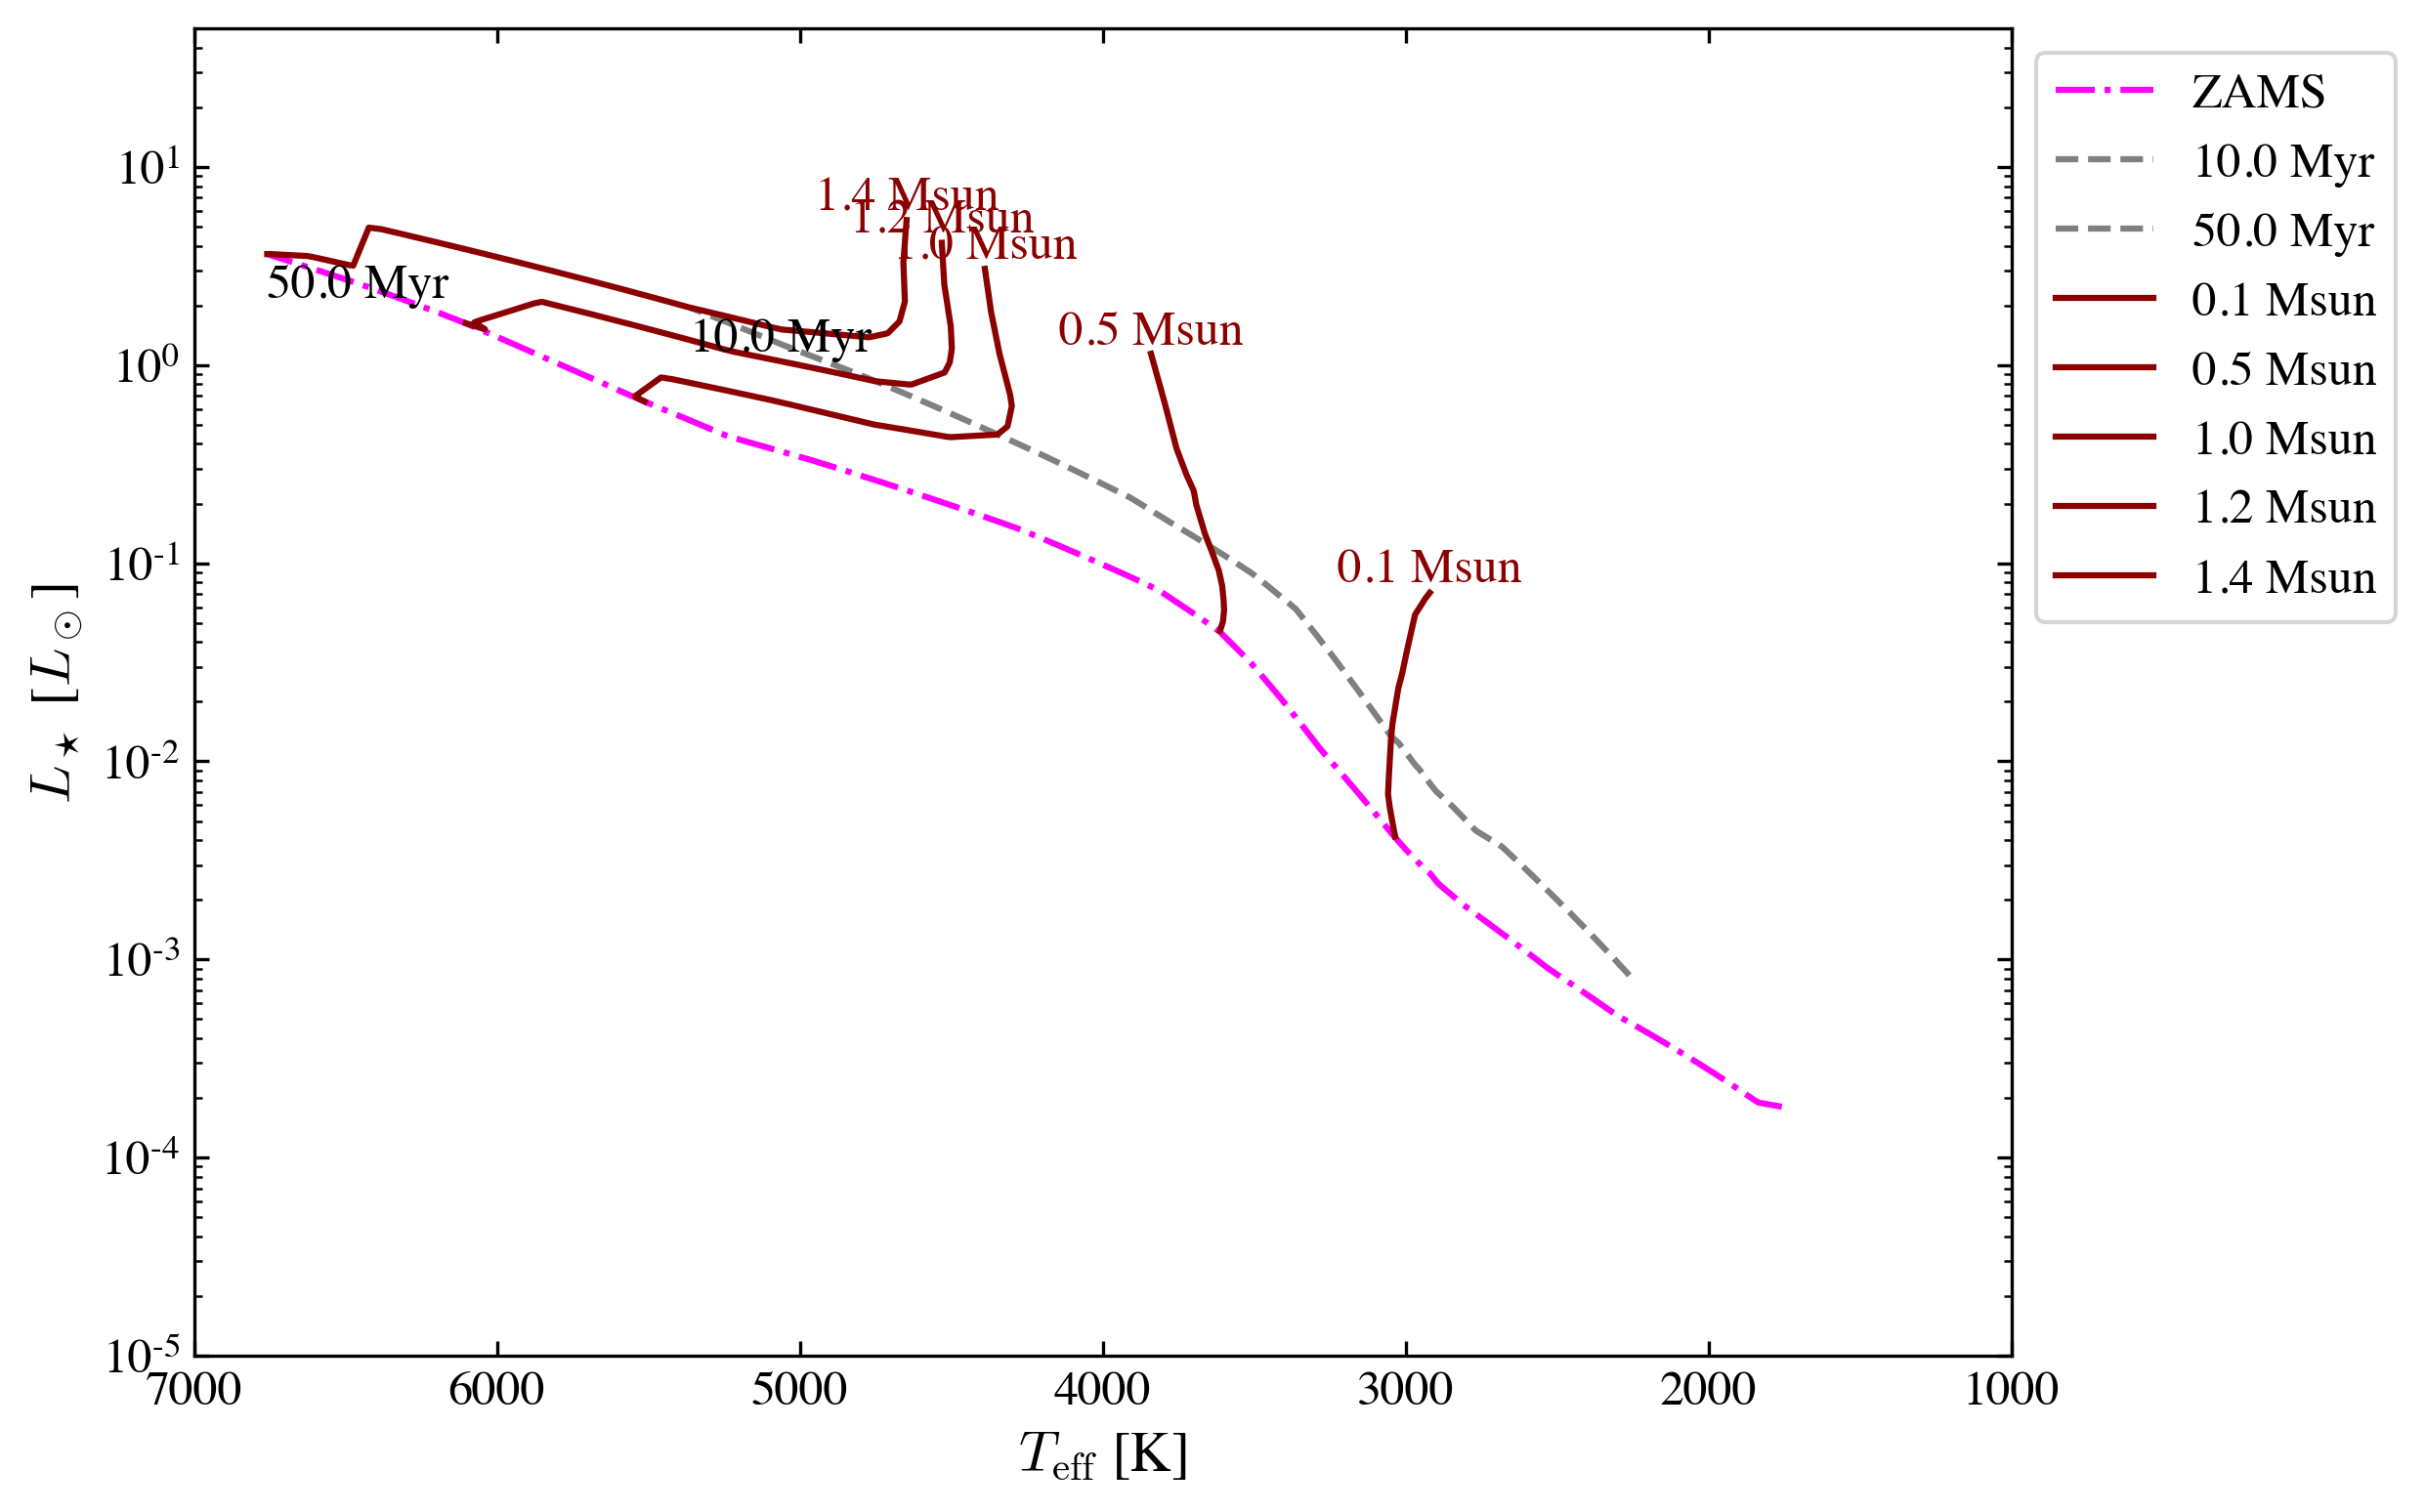

In [2]:
# Initialize the isochrone class with default data directory
isochrone = ysoisochrone.isochrone.Isochrone()

# isochrone.set_tracks('Baraffe2015')

# mat_file_dir = './isochrones_data/Baraffe_AgeMassGrid_YSO_up1Gyr_matrix.mat'
# isochrone.set_tracks('customize', load_file=mat_file_dir)

mat_file_dir = './isochrones_data_archive/Baraffe_fromidlsav_AgeMassGrid.mat'
isochrone.set_tracks('customize', load_file=mat_file_dir)

fig, ax = plt.subplots(figsize=(8, 6))

# # find the ZAMS
# teff_zams, lum_zams, mask_pms = ysoisochrone.utils.find_zams_curve(isochrone)

# # Plot ZAMS curve
# ax.plot(teff_zams, lum_zams, 'b-', label='ZAMS')

# ysoisochrone.plotting.plot_hr_diagram(isochrone, ax_set=ax, 
#                                       ages_to_plot=[0.5e6, 1.0e6, 2.0e6, 3.0e6, 5.0e6, 10.0e6, 30.0e6, 100.0e6], 
#                                       masses_to_plot=[0.2, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.39],
#                                       xlim_set=[6000, 3000], ylim_set=[0.01, 50.0])

ysoisochrone.plotting.plot_hr_diagram(isochrone, ax_set=ax, 
                                      ages_to_plot=[0.5e6, 10.0e6, 50.0e6, 1000.0e6], 
                                      masses_to_plot=[0.1, 0.5, 1.0, 1.2, 1.39],
                                      xlim_set=[7000, 1000], ylim_set=[1e-5, 50.0], 
                                      zams_curve=True)

# ax.set_xlim(6000, 2800)
# ax.set_ylim(0.005, 50)
plt.show()

## How about PARSEC and Feiden?

In [3]:
from ysoisochrone import utils

# data_points = utils.read_parsec_v2p0_tab_file(parsec_dir='./isochrones_data/PARSECv2p0/VAR_ROT0.00_SH_Z0.014_Y0.273/')

# # Create meshgrid and interpolate the data onto the grid
# # masses_i, log_age_i, logtlogl_grid, _, _ = utils.create_meshgrid(data_points)
# masses_i, log_age_i, logtlogl_grid, masses_grid, log_age_grid = utils.create_meshgrid(data_points)

# output_mat_file = os.path.join('isochrones_data', 'PARSECv2p0_AgeMassGrid_YSO_refrained_matrix.mat')

# # Save the parsed data to a .mat file
# utils.save_as_mat(masses_i, log_age_i, logtlogl_grid, output_mat_file)
# print(f"File saved as: {output_mat_file}")

# # set tracks
# isochrone = ysoisochrone.isochrone.Isochrone()
# mat_file_dir = output_mat_file

# isochrone.set_tracks('customize', load_file=mat_file_dir)

# # find the ZAMS
# teff_zams, lum_zams, mask_pms = utils.find_zams_curve(isochrone)

# output_mat_file = os.path.join('isochrones_data', 'PARSECv2p0_AgeMassGrid_YSO_refrained_masked_matrix.mat')

# logtlogl_grid[:, :, 0] *= mask_pms
# logtlogl_grid[:, :, 1] *= mask_pms

# # Save the parsed data to a .mat file
# utils.save_as_mat(masses_i, log_age_i, logtlogl_grid, output_mat_file)
# print(f"File saved as: {output_mat_file}")

In [4]:
# Initialize the isochrone class with default data directory
isochrone = ysoisochrone.isochrone.Isochrone()

# set tracks
# isochrone.set_tracks('PARSEC_v2p0')
isochrone.set_tracks('Feiden2016')

# # set tracks
# isochrone = ysoisochrone.isochrone.Isochrone()
# mat_file_dir = './isochrones_data/PARSECv2p0_AgeMassGrid_YSO_refrained_matrix.mat'
# # mat_file_dir = './isochrones_data/PARSECv2p0_AgeMassGrid_YSO_refrained_masked_matrix.mat'
# isochrone.set_tracks('customize', load_file=mat_file_dir)

# find the ZAMS
teff_zams, lum_zams, mask_pms = utils.find_zams_curve(isochrone)

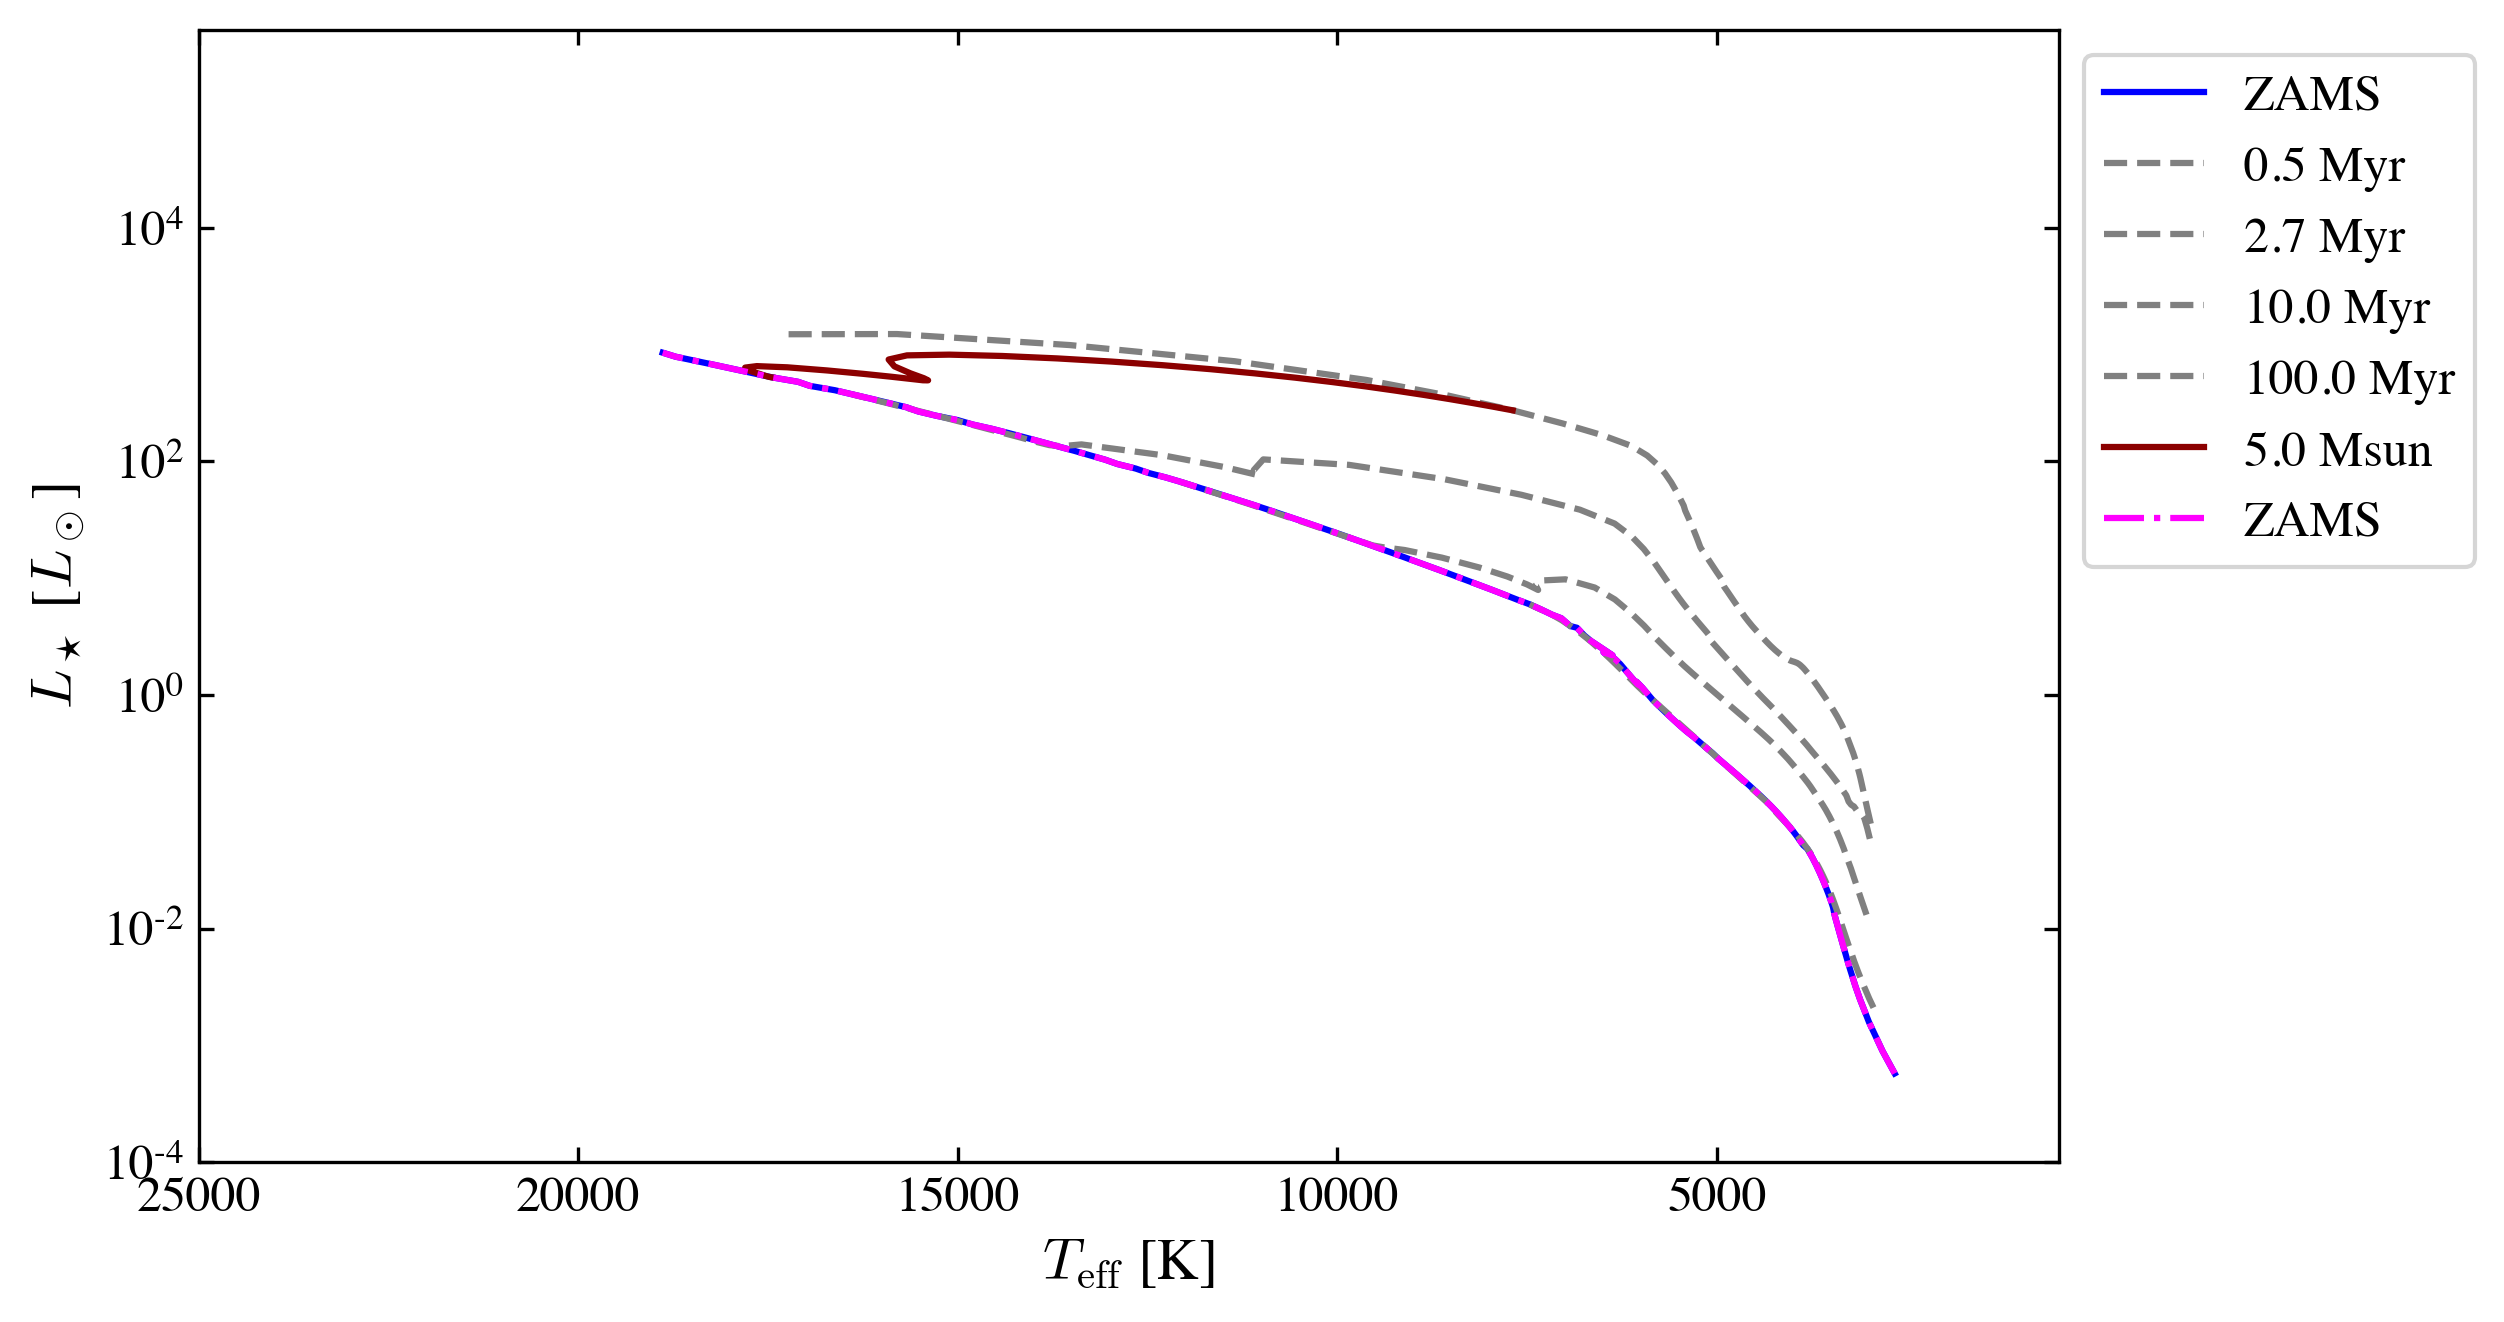

In [5]:
fig, axes = plt.subplots(1,1,figsize=(8, 5))

ax = axes

# Plot ZAMS curve
ax.plot(teff_zams, lum_zams, 'b-', label='ZAMS')

# Apply the mask to your plotting code
teff_iso = 10**isochrone.logtlogl[:, :, 0]  # Teff
lum_iso = 10**isochrone.logtlogl[:, :, 1]   # L/Lo

for age in [0.5e6, 2.7e6, 10.0e6, 100.0e6]:  # Example isochrone ages to plot
    idx_age = np.nanargmin(np.abs(isochrone.log_age - np.log10(age)))  # Find the closest age

    # Filter out Teff and Luminosity using the pre-main-sequence mask
    teff_filtered = teff_iso[idx_age, :][mask_pms[idx_age, :]]
    lum_filtered = lum_iso[idx_age, :][mask_pms[idx_age, :]]

    # Plot the pre-main-sequence part of the isochrone
    ax.plot(teff_filtered, lum_filtered, '--', label=f'{age/1e6:.1f} Myr', color='grey')

# Plot the mass tracks as well (like you already have)
for mass in [5.0]: # 0.5, 1.0, 1.2, 1.4, 2.0, 3.0, 5.0, 10.0, 
    idx_mass = np.nanargmin(np.abs(isochrone.masses - mass))  # Find closest mass
    teff_filtered = teff_iso[:, idx_mass][mask_pms[:, idx_mass]]
    lum_filtered = lum_iso[:, idx_mass][mask_pms[:, idx_mass]]
    # ax.plot(teff_iso[:, idx_mass], lum_iso[:, idx_mass], label=f'{mass:.1f} Msun', color='pink')
    ax.plot(teff_filtered, lum_filtered, '-', label=f'{mass:.1f} Msun', color='darkred')
    
ysoisochrone.plotting.plot_hr_diagram(isochrone, ax_set=ax, 
                                      ages_to_plot=[], 
                                      masses_to_plot=[],
                                      xlim_set=[2.5e4, 500], ylim_set=[1e-4, 5e5])

plt.show()

In [6]:
# for age in [5e7]:  # Example isochrone ages to plot
#     idx_age = np.nanargmin(np.abs(isochrone.log_age - np.log10(age)))  # Find the closest age

#     # Filter out Teff and Luminosity using the pre-main-sequence mask
#     teff_filtered = teff_iso[idx_age, :][mask_pms[idx_age, :]]
#     lum_filtered = lum_iso[idx_age, :][mask_pms[idx_age, :]]

## Test MIST

In [7]:
# Initialize the isochrone class with default data directory
isochrone = ysoisochrone.isochrone.Isochrone()

# set tracks
# isochrone.set_tracks('PARSEC_v2p0')
isochrone.set_tracks('MIST')

# # set tracks
# isochrone = ysoisochrone.isochrone.Isochrone()
# mat_file_dir = './isochrones_data/PARSECv2p0_AgeMassGrid_YSO_refrained_matrix.mat'
# # mat_file_dir = './isochrones_data/PARSECv2p0_AgeMassGrid_YSO_refrained_masked_matrix.mat'
# isochrone.set_tracks('customize', load_file=mat_file_dir)

# find the ZAMS
teff_zams, lum_zams, mask_pms = utils.find_zams_curve(isochrone)

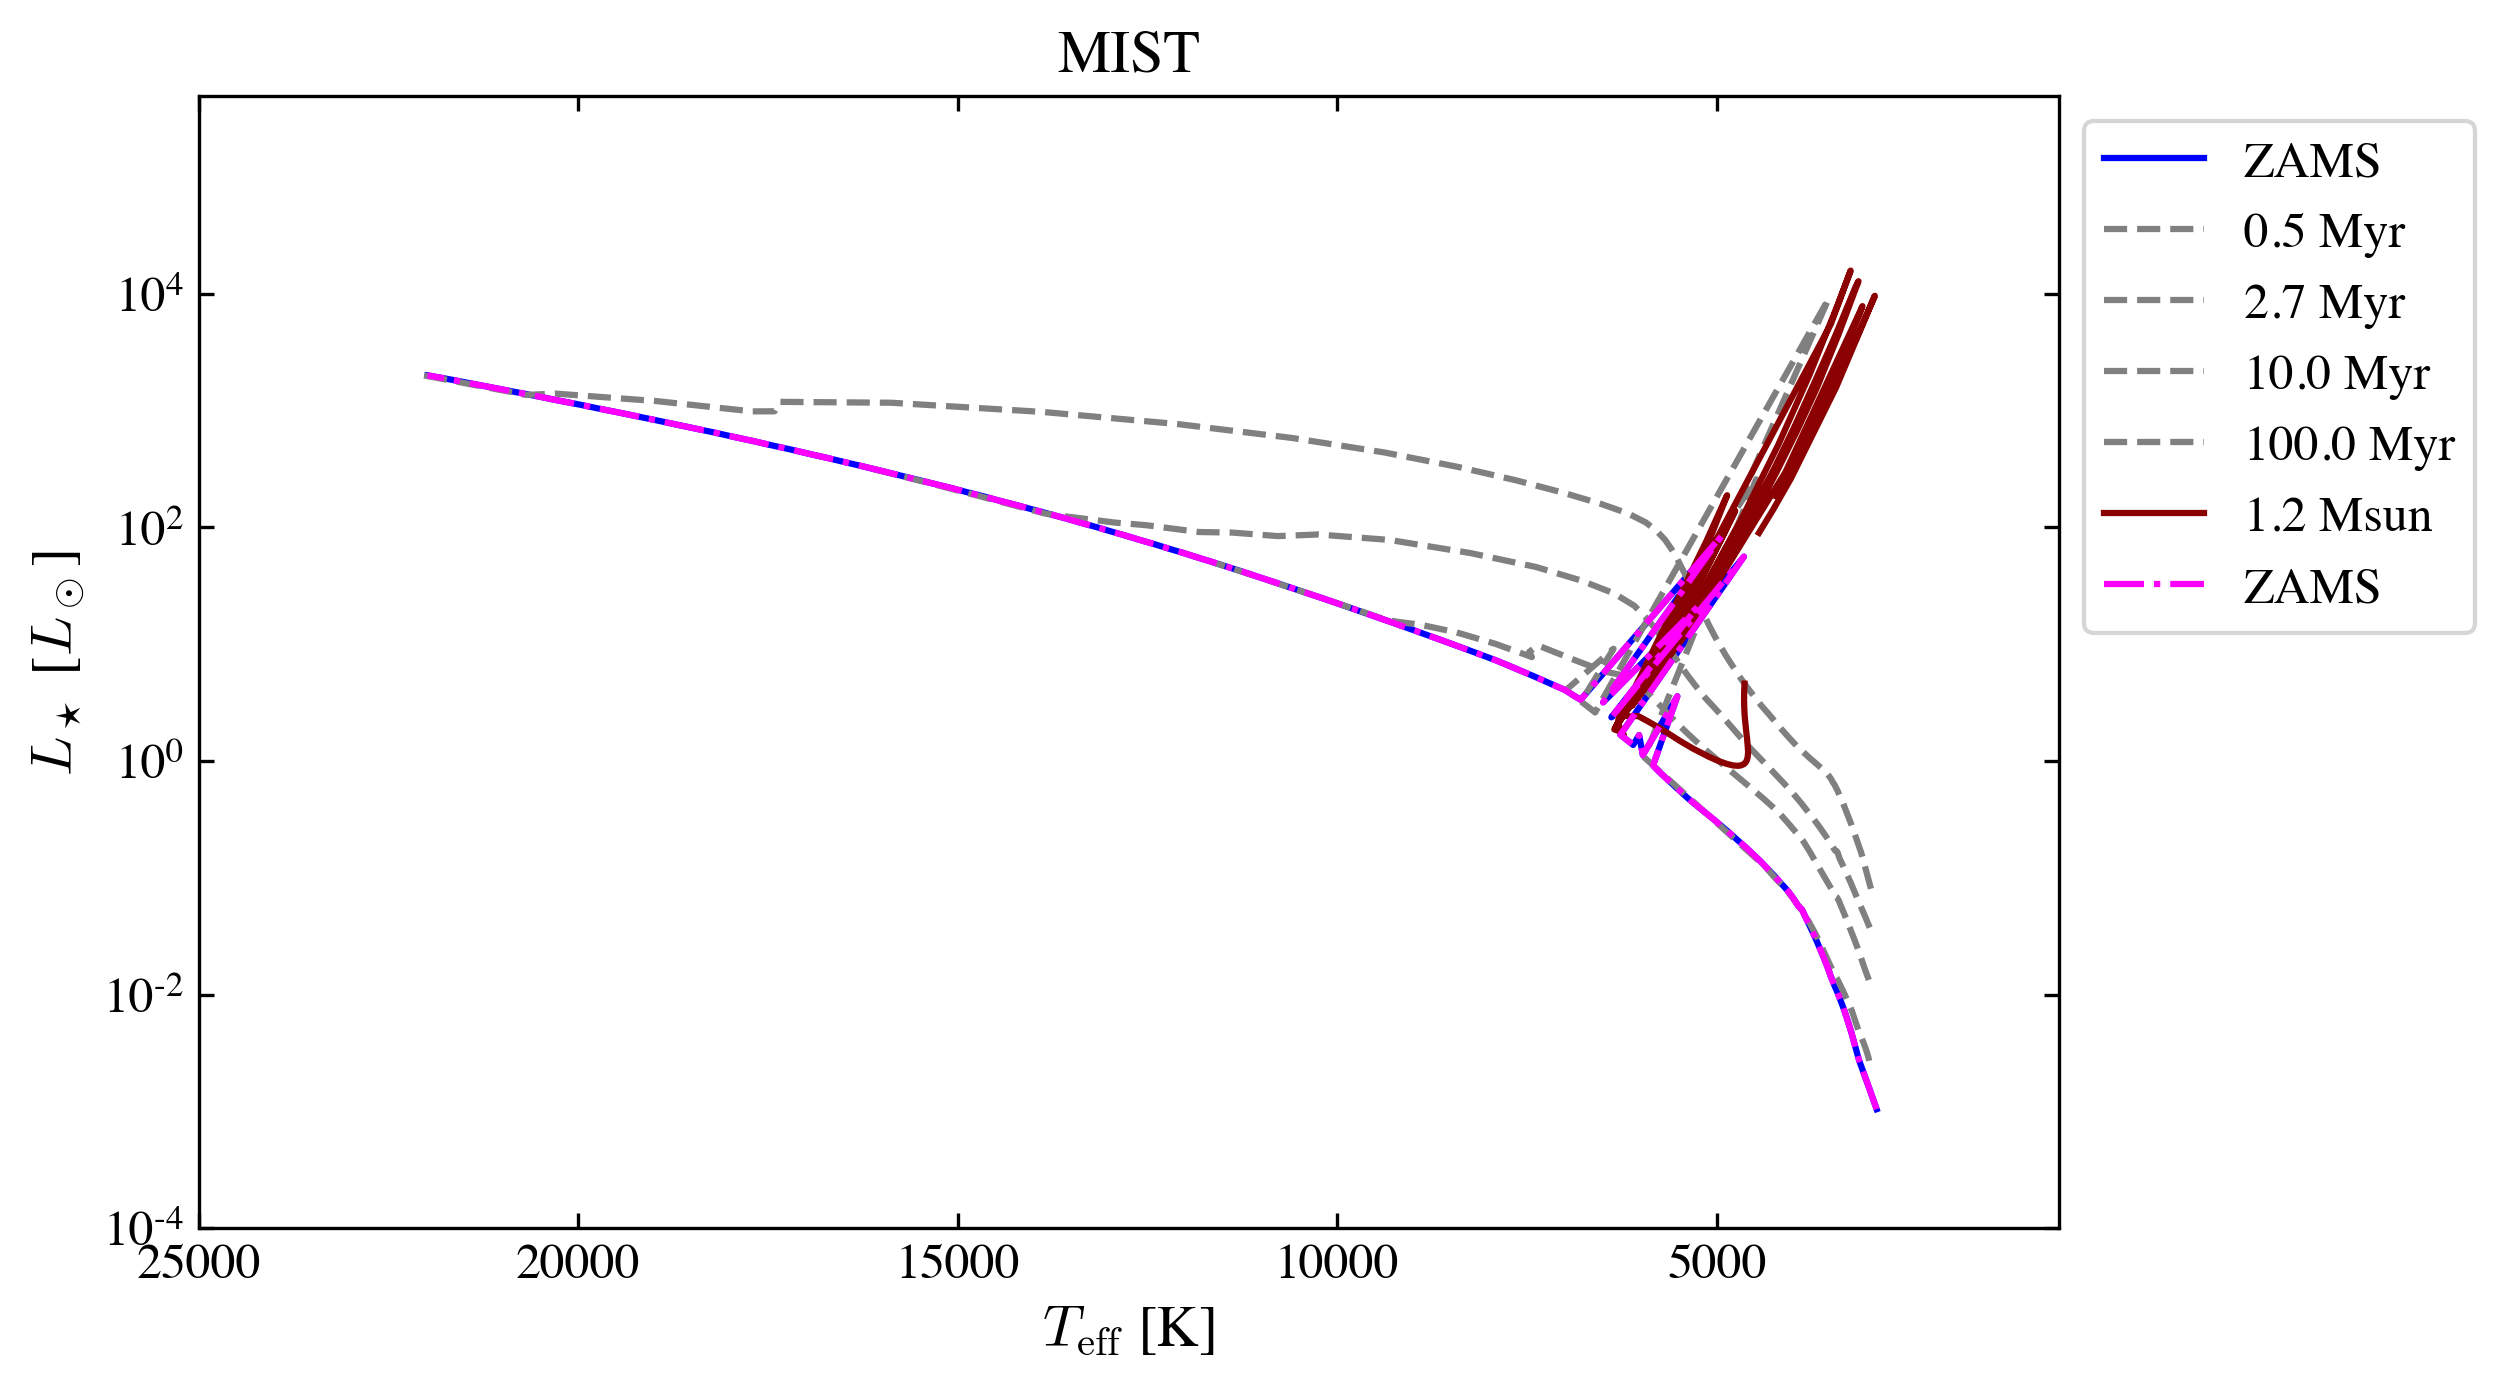

In [9]:
fig, axes = plt.subplots(1,1,figsize=(8, 5))

ax = axes

# Plot ZAMS curve
ax.plot(teff_zams, lum_zams, 'b-', label='ZAMS')

# Apply the mask to your plotting code
teff_iso = 10**isochrone.logtlogl[:, :, 0]  # Teff
lum_iso = 10**isochrone.logtlogl[:, :, 1]   # L/Lo

for age in [0.5e6, 2.7e6, 10.0e6, 100.0e6]:  # Example isochrone ages to plot
    idx_age = np.nanargmin(np.abs(isochrone.log_age - np.log10(age)))  # Find the closest age

    # Filter out Teff and Luminosity using the pre-main-sequence mask
    teff_filtered = teff_iso[idx_age, :][mask_pms[idx_age, :]]
    lum_filtered = lum_iso[idx_age, :][mask_pms[idx_age, :]]

    # Plot the pre-main-sequence part of the isochrone
    ax.plot(teff_filtered, lum_filtered, '--', label=f'{age/1e6:.1f} Myr', color='grey')

# Plot the mass tracks as well (like you already have)
for mass in [1.2]: # 0.5, 1.0, 1.2, 1.4, 2.0, 3.0, 5.0, 10.0, 
    idx_mass = np.nanargmin(np.abs(isochrone.masses - mass))  # Find closest mass
    teff_filtered = teff_iso[:, idx_mass][mask_pms[:, idx_mass]]
    lum_filtered = lum_iso[:, idx_mass][mask_pms[:, idx_mass]]
    # ax.plot(teff_iso[:, idx_mass], lum_iso[:, idx_mass], label=f'{mass:.1f} Msun', color='pink')
    ax.plot(teff_filtered, lum_filtered, '-', label=f'{mass:.1f} Msun', color='darkred')
    
ysoisochrone.plotting.plot_hr_diagram(isochrone, ax_set=ax, 
                                      ages_to_plot=[], 
                                      masses_to_plot=[],
                                      xlim_set=[2.5e4, 500], ylim_set=[1e-4, 5e5])

ax.set_title('MIST')

plt.show()

the hrd for all

NameError: name 'zams_idx_t' is not defined

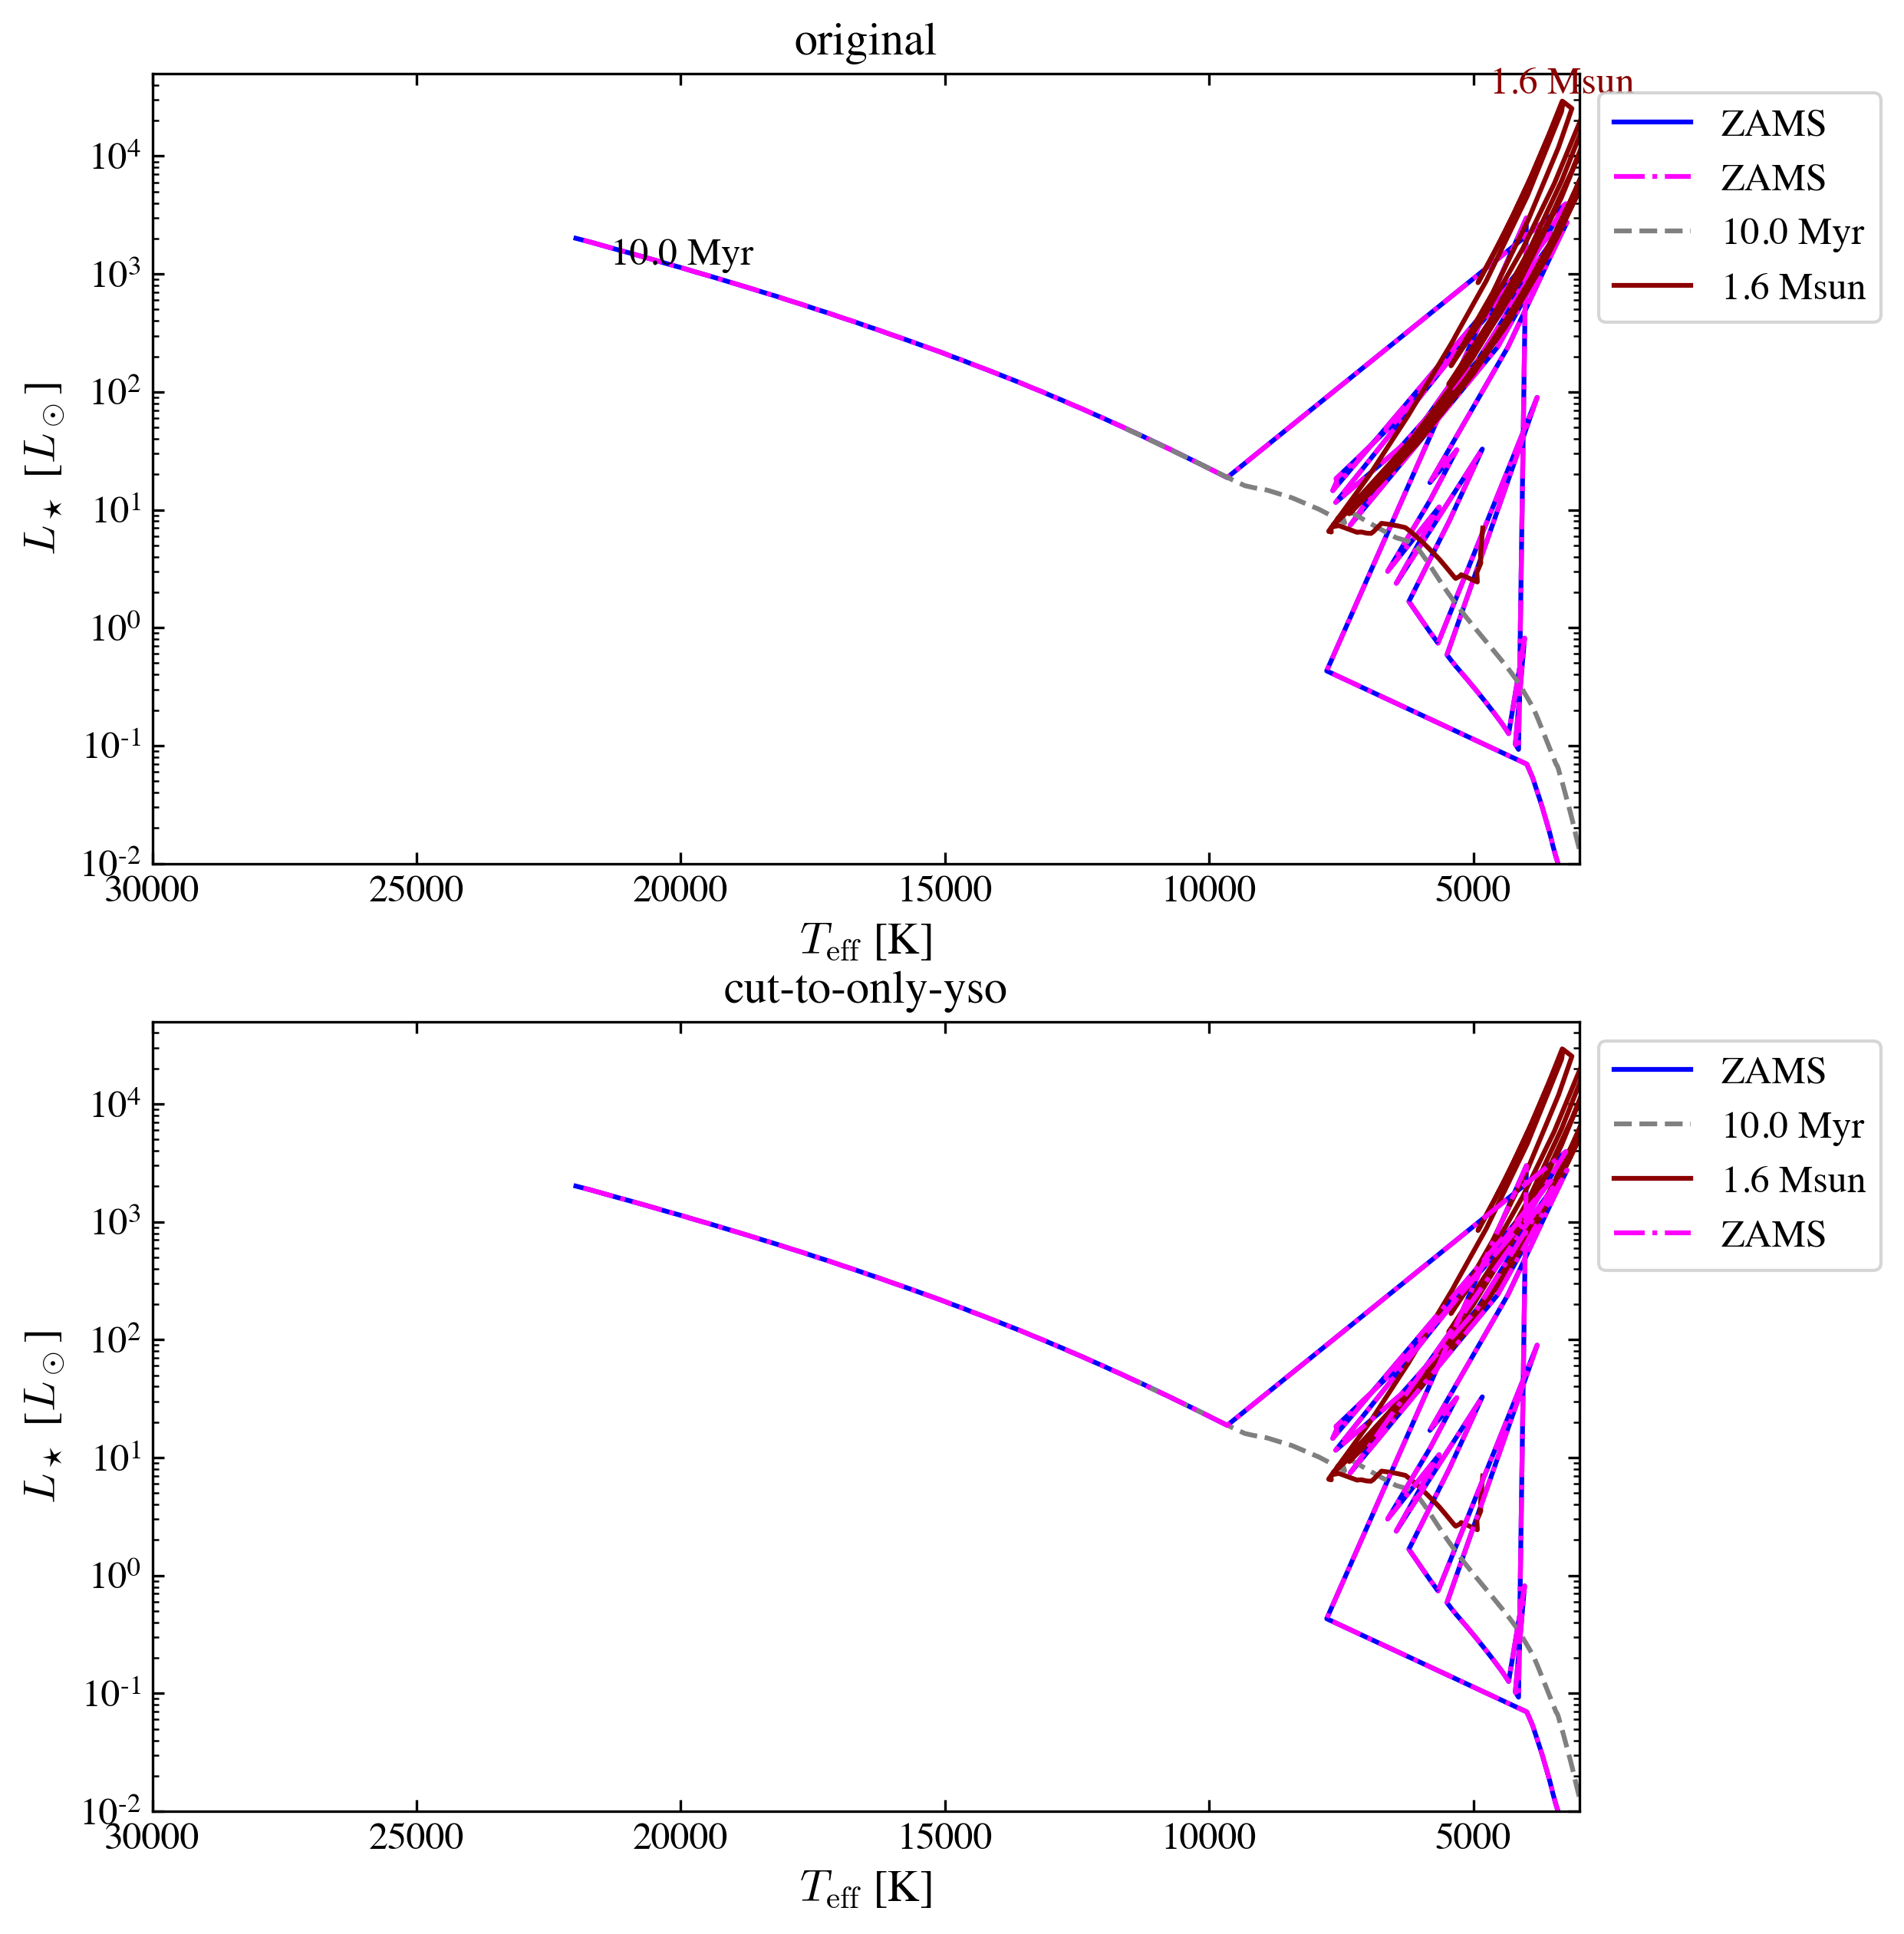

In [9]:
ages_to_plot = [10.e6] # [0.5e6, 2.7e6, 10.0e6, 100.0e6]
masses_to_plot = [1.6] # [0.5, 1.0, 1.2, 1.4, 2.0, 3.0]

fig, axes = plt.subplots(2,1,figsize=(8, 10))

ax = axes[0]

ax.set_title('original')

# Plot ZAMS curve
ax.plot(teff_zams, lum_zams, 'b-', label='ZAMS')

ysoisochrone.plotting.plot_hr_diagram(isochrone, ax_set=ax, 
                                      ages_to_plot=ages_to_plot, 
                                      masses_to_plot=masses_to_plot,
                                      xlim_set=[3e4, 3000], ylim_set=[0.01, 5e4])

ax = axes[1]

ax.set_title('cut-to-only-yso')

# Plot ZAMS curve
ax.plot(teff_zams, lum_zams, 'b-', label='ZAMS')

# Apply the mask to your plotting code
teff_iso = 10**isochrone.logtlogl[:, :, 0]  # Teff
lum_iso = 10**isochrone.logtlogl[:, :, 1]   # L/Lo

for age in ages_to_plot:  # Example isochrone ages to plot
    idx_age = np.nanargmin(np.abs(isochrone.log_age - np.log10(age)))  # Find the closest age

    # Filter out Teff and Luminosity using the pre-main-sequence mask
    teff_filtered = teff_iso[idx_age, :][mask_pms[idx_age, :]]
    lum_filtered = lum_iso[idx_age, :][mask_pms[idx_age, :]]

    # Plot the pre-main-sequence part of the isochrone
    ax.plot(teff_filtered, lum_filtered, '--', label=f'{age/1e6:.1f} Myr', color='grey')

# Plot the mass tracks as well (like you already have)
for mass in masses_to_plot: # 0.5, 1.0, 1.2, 1.4, 2.0, 3.0, 5.0, 10.0, 
    idx_mass = np.nanargmin(np.abs(isochrone.masses - mass))  # Find closest mass
    teff_filtered = teff_iso[:, idx_mass][mask_pms[:, idx_mass]]
    lum_filtered = lum_iso[:, idx_mass][mask_pms[:, idx_mass]]
    ax.plot(teff_filtered, lum_filtered, '-', label=f'{mass:.1f} Msun', color='darkred')
    
ysoisochrone.plotting.plot_hr_diagram(isochrone, ax_set=ax, 
                                      ages_to_plot=[], 
                                      masses_to_plot=[],
                                      xlim_set=[3e4, 3000], ylim_set=[0.01, 5e4])

ax.scatter(teff_iso[zams_idx_t, idx_mass], lum_iso[zams_idx_t, idx_mass],marker='*',color='red')

plt.show()

other diagnostic plot

8.298970004335963
using the tip of the Teff as the ZAMS point for mass 0.60 Msun


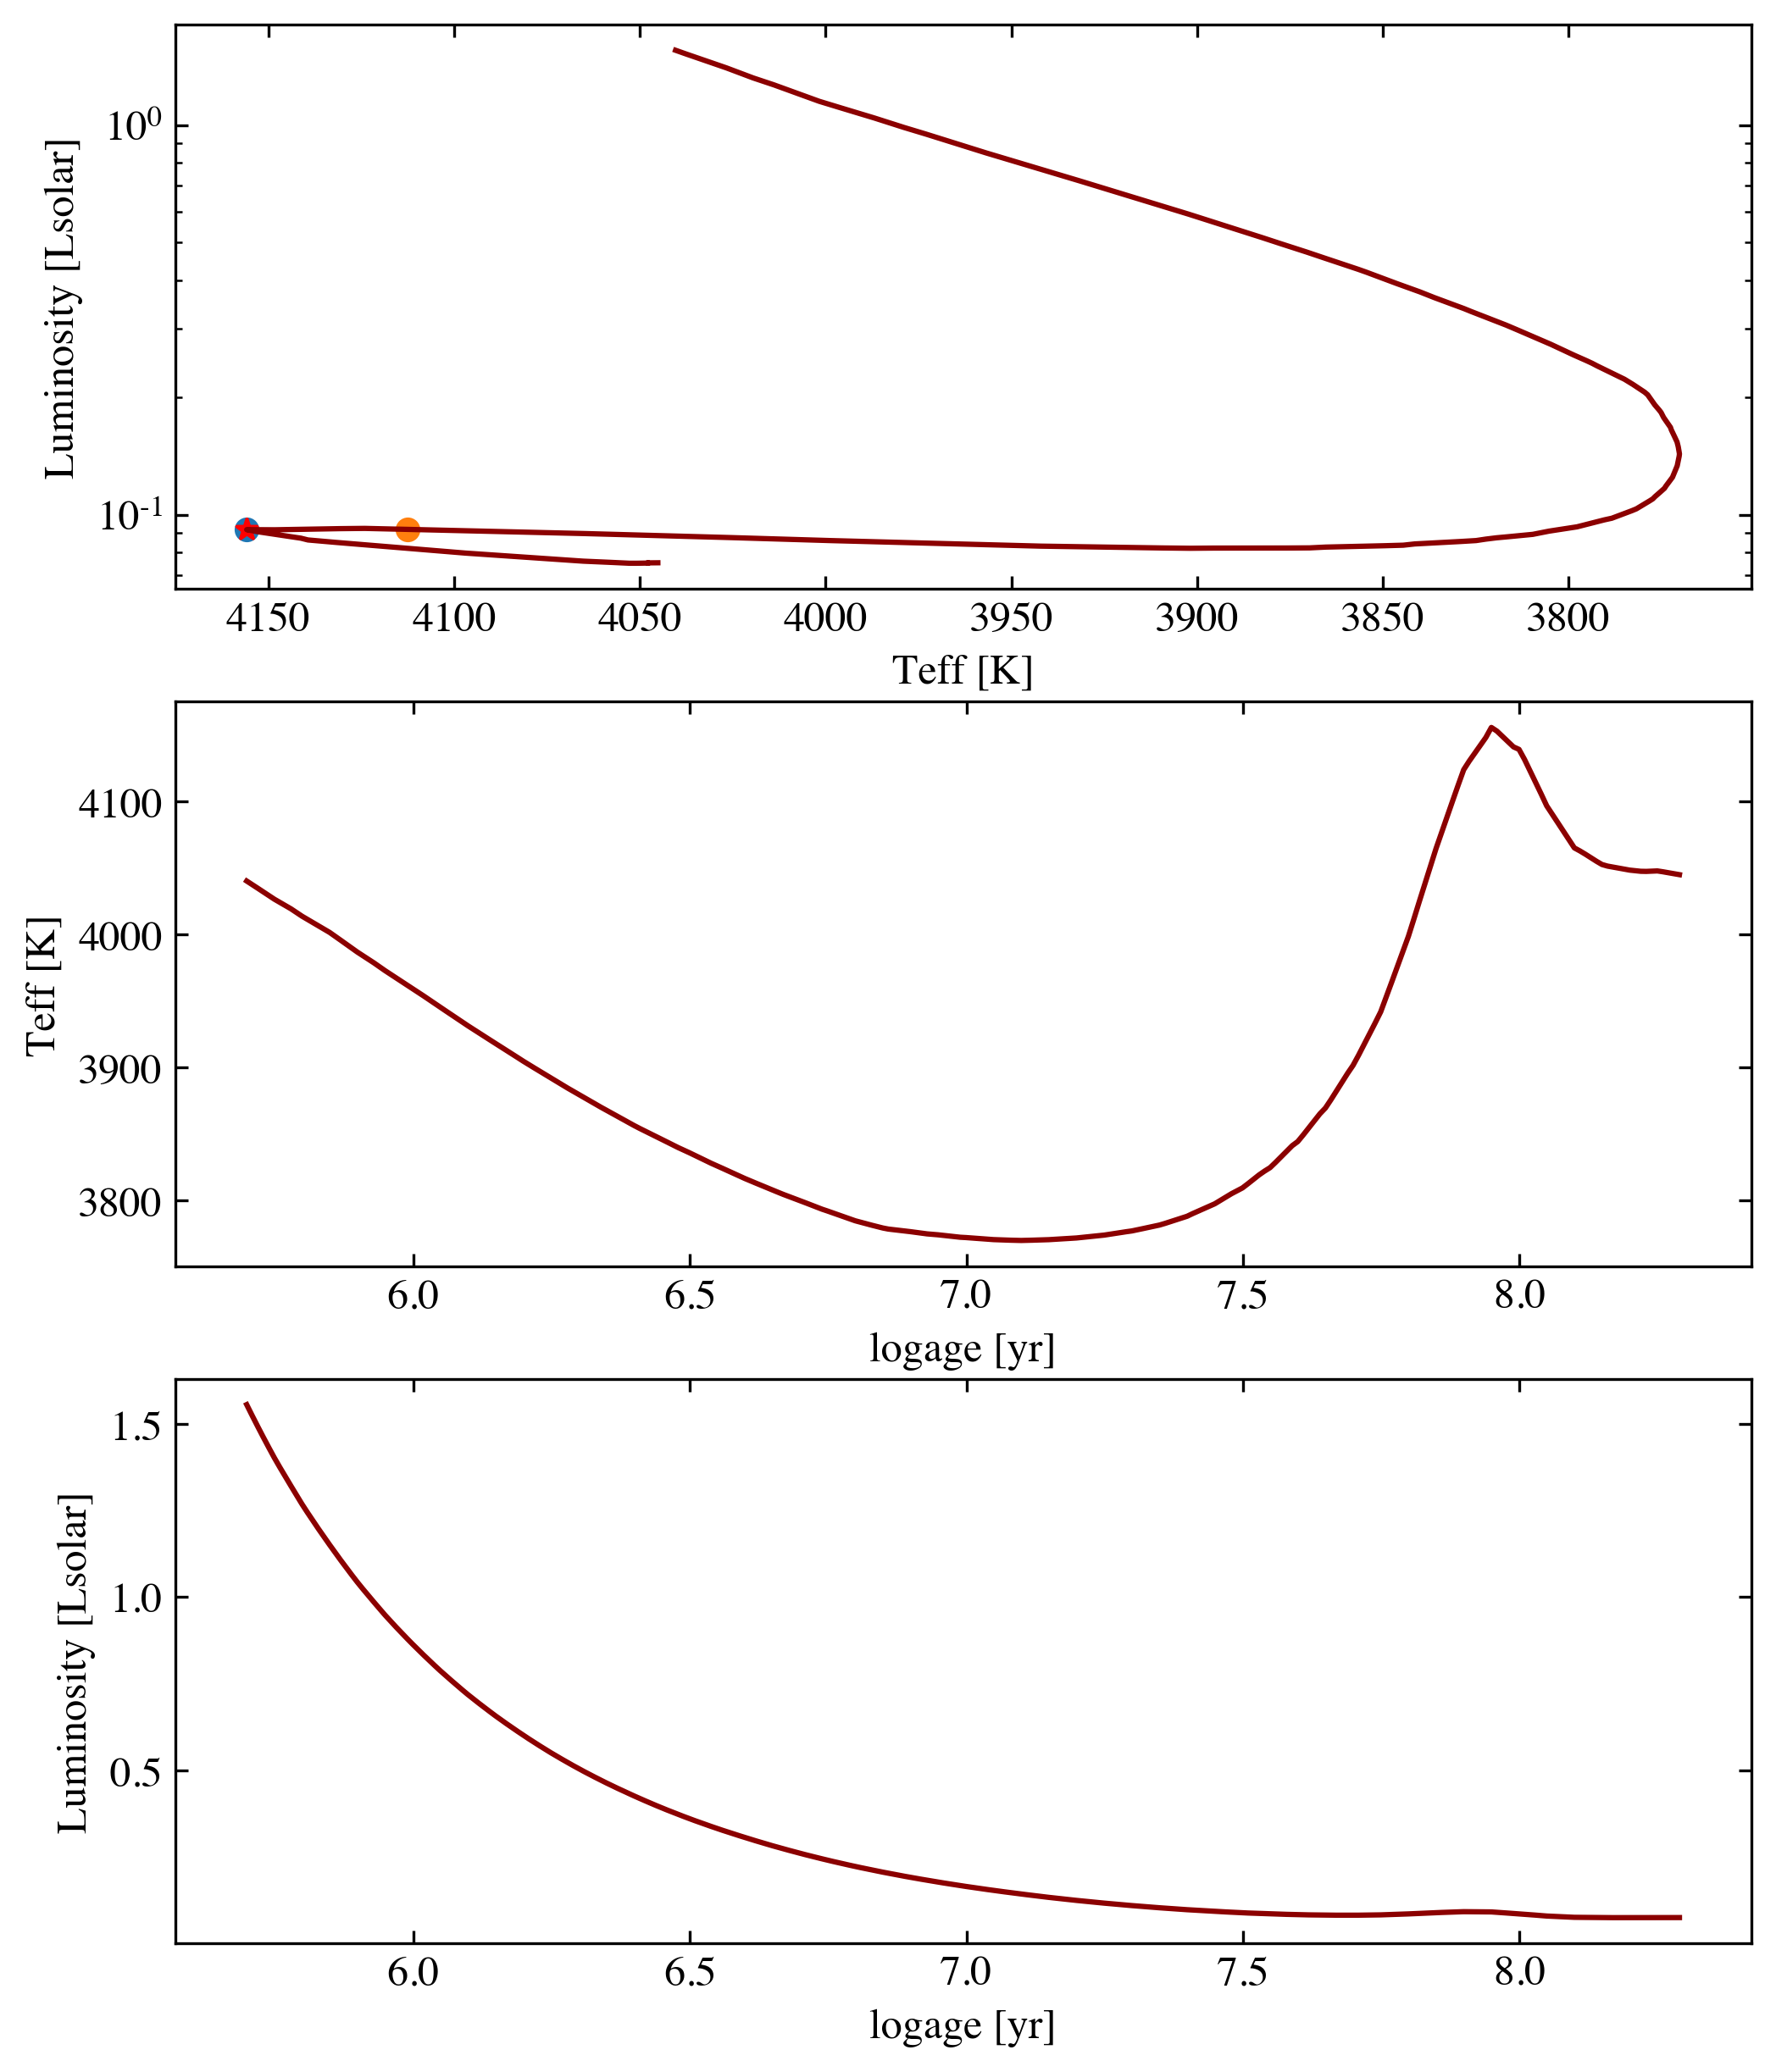

In [351]:
fig, axes = plt.subplots(3, 1, figsize=(8, 10))

teff_iso = 10**isochrone.logtlogl[:, :, 0]  # Teff
lum_iso = 10**isochrone.logtlogl[:, :, 1]   # L/Lo
mass = 0.6 # solar masses
idx_mass = np.nanargmin(np.abs(isochrone.masses - mass))  # Find closest mass

log_age_max_preset = 9.5
idx_age_max_preset = np.nanargmin(np.abs(isochrone.log_age - log_age_max_preset))

teff_track = teff_iso[:idx_age_max_preset, idx_mass]
lum_track = lum_iso[:idx_age_max_preset, idx_mass]
age_track = 10**isochrone.log_age[:idx_age_max_preset]

delta_teff = np.diff(teff_track)
delta_lum = np.diff(lum_track)
delta_age = np.diff(age_track)

dteff_dage = delta_teff/delta_age
dlum_dage = delta_lum/delta_age

# first find the location that evolves really slow and those positions should be main-sequence phase
percentile = np.percentile(np.abs(dlum_dage), 5)
# Get the indices of the values that are less than or equal to the percentile
idx_age_max = int(np.percentile(np.where(np.abs(dlum_dage) <= percentile)[0], 5))
log_age_max = isochrone.log_age[idx_age_max]
# log_age_max = 7.8 # 7.92
# idx_age_max = np.nanargmin(np.abs(isochrone.log_age - log_age_max))

print(log_age_max)

## For plot and to find the point
teff_iso = 10**isochrone.logtlogl[:idx_age_max, :, 0]  # Teff
lum_iso = 10**isochrone.logtlogl[:idx_age_max, :, 1]   # L/Lo

teff_track = teff_iso[:, idx_mass]
lum_track = lum_iso[:, idx_mass]
age_track = 10**isochrone.log_age[:idx_age_max]

delta_teff = np.diff(teff_track)
delta_lum = np.diff(lum_track)
delta_age = np.diff(age_track)

dteff_dage = delta_teff/delta_age
dlum_dage = delta_lum/delta_age

idx_j = np.nanargmin(np.abs(teff_track - np.nanmax(teff_track)))

teff_track_part = teff_track[:idx_j+1]
lum_track_part = lum_track[:idx_j+1]
for fraction_t in np.arange(0.5, 0, -0.1):
    idx_j2 = np.nanargmin(np.abs(teff_track_part - \
        (teff_track[idx_j] - np.abs(teff_track[idx_j]-teff_track_part[0])*fraction_t)))
    if lum_track_part[idx_j2] > lum_track[idx_j]:
        break

# ZAMS condition for solar-mass stars
# 1. Has low luminosity locally
# 2. Luminosity decreasing before this point and 
# increasing slowly or stabilizing after this point
# 3. Teff decreasing before this point and 
# increasing slowly or stabilizing after this point
for j in np.arange(idx_j-1, 0, -1):
    # we do this backwards from the last point of main-sequence star.
    # starting from the point with largest Teff, and then going backwards
    # (finding the tip of Henyey track)
    if (delta_lum[j-1] < 0) and (delta_lum[j] > 0) and \
        (delta_teff[j-1] < 0) and (delta_teff[j] > 0):
        zams_idx_t = j
        break
    if j <= idx_j2:
        zams_idx_t = idx_j
        print('using the tip of the Teff as the ZAMS point for mass %.2f Msun'%(mass))
        break
    
teff_track_part = teff_track[idx_j2:idx_j]
lum_track_part = lum_track[idx_j2:idx_j]

# idx_j3 = np.nanargmin(np.abs(lum_track_part - np.nanmin(lum_track_part)))

# zams_idx_p = ysoisochrone.utils.find_zams_index(10**isochrone.logtlogl[:, idx_mass, 0], 10**isochrone.logtlogl[:, idx_mass, 1], age_track=10**isochrone.log_age)

ax = axes[0]
ax.plot(teff_iso[:idx_age_max, idx_mass], lum_iso[:idx_age_max, idx_mass], '-', label=f'{mass:.1f} Msun', color='darkred')

# ax.scatter(teff_iso[zams_idx_p, idx_mass], lum_iso[zams_idx_p, idx_mass], marker='p')

ax.scatter(teff_iso[idx_j, idx_mass], lum_iso[idx_j, idx_mass])
ax.scatter(teff_iso[idx_j2, idx_mass], lum_iso[idx_j2, idx_mass])
# ax.scatter(teff_iso[idx_j2+idx_j3, idx_mass], lum_iso[idx_j2+idx_j3, idx_mass],marker='*',color='magenta')
ax.scatter(teff_iso[zams_idx_t, idx_mass], lum_iso[zams_idx_t, idx_mass],marker='*',color='red')
# ax.scatter(teff_iso[idx_j2+idx_j3+10, idx_mass], lum_iso[idx_j2+idx_j3+10, idx_mass],marker='*',color='magenta')

ax.set_xlabel('Teff [K]')
ax.set_ylabel('Luminosity [Lsolar]')

ax.invert_xaxis()
ax.set_yscale('log')

# ax.set_xlim(6500, 6000)
# ax.set_ylim(1e0, 1e1)

ax = axes[1]
ax.plot(isochrone.log_age[:idx_age_max], teff_iso[:idx_age_max, idx_mass], '-', label=f'{mass:.1f} Msun', color='darkred')

ax.set_xlabel('logage [yr]')
ax.set_ylabel('Teff [K]')
# ax.set_ylabel('Luminosity [Lsolar]')

# ax.set_yscale('log')

ax = axes[2]
ax.plot(isochrone.log_age[:idx_age_max], lum_iso[:idx_age_max, idx_mass], '-', label=f'{mass:.1f} Msun', color='darkred')

ax.set_xlabel('logage [yr]')
ax.set_ylabel('Luminosity [Lsolar]')

# ax.set_yscale('log')

plt.show()

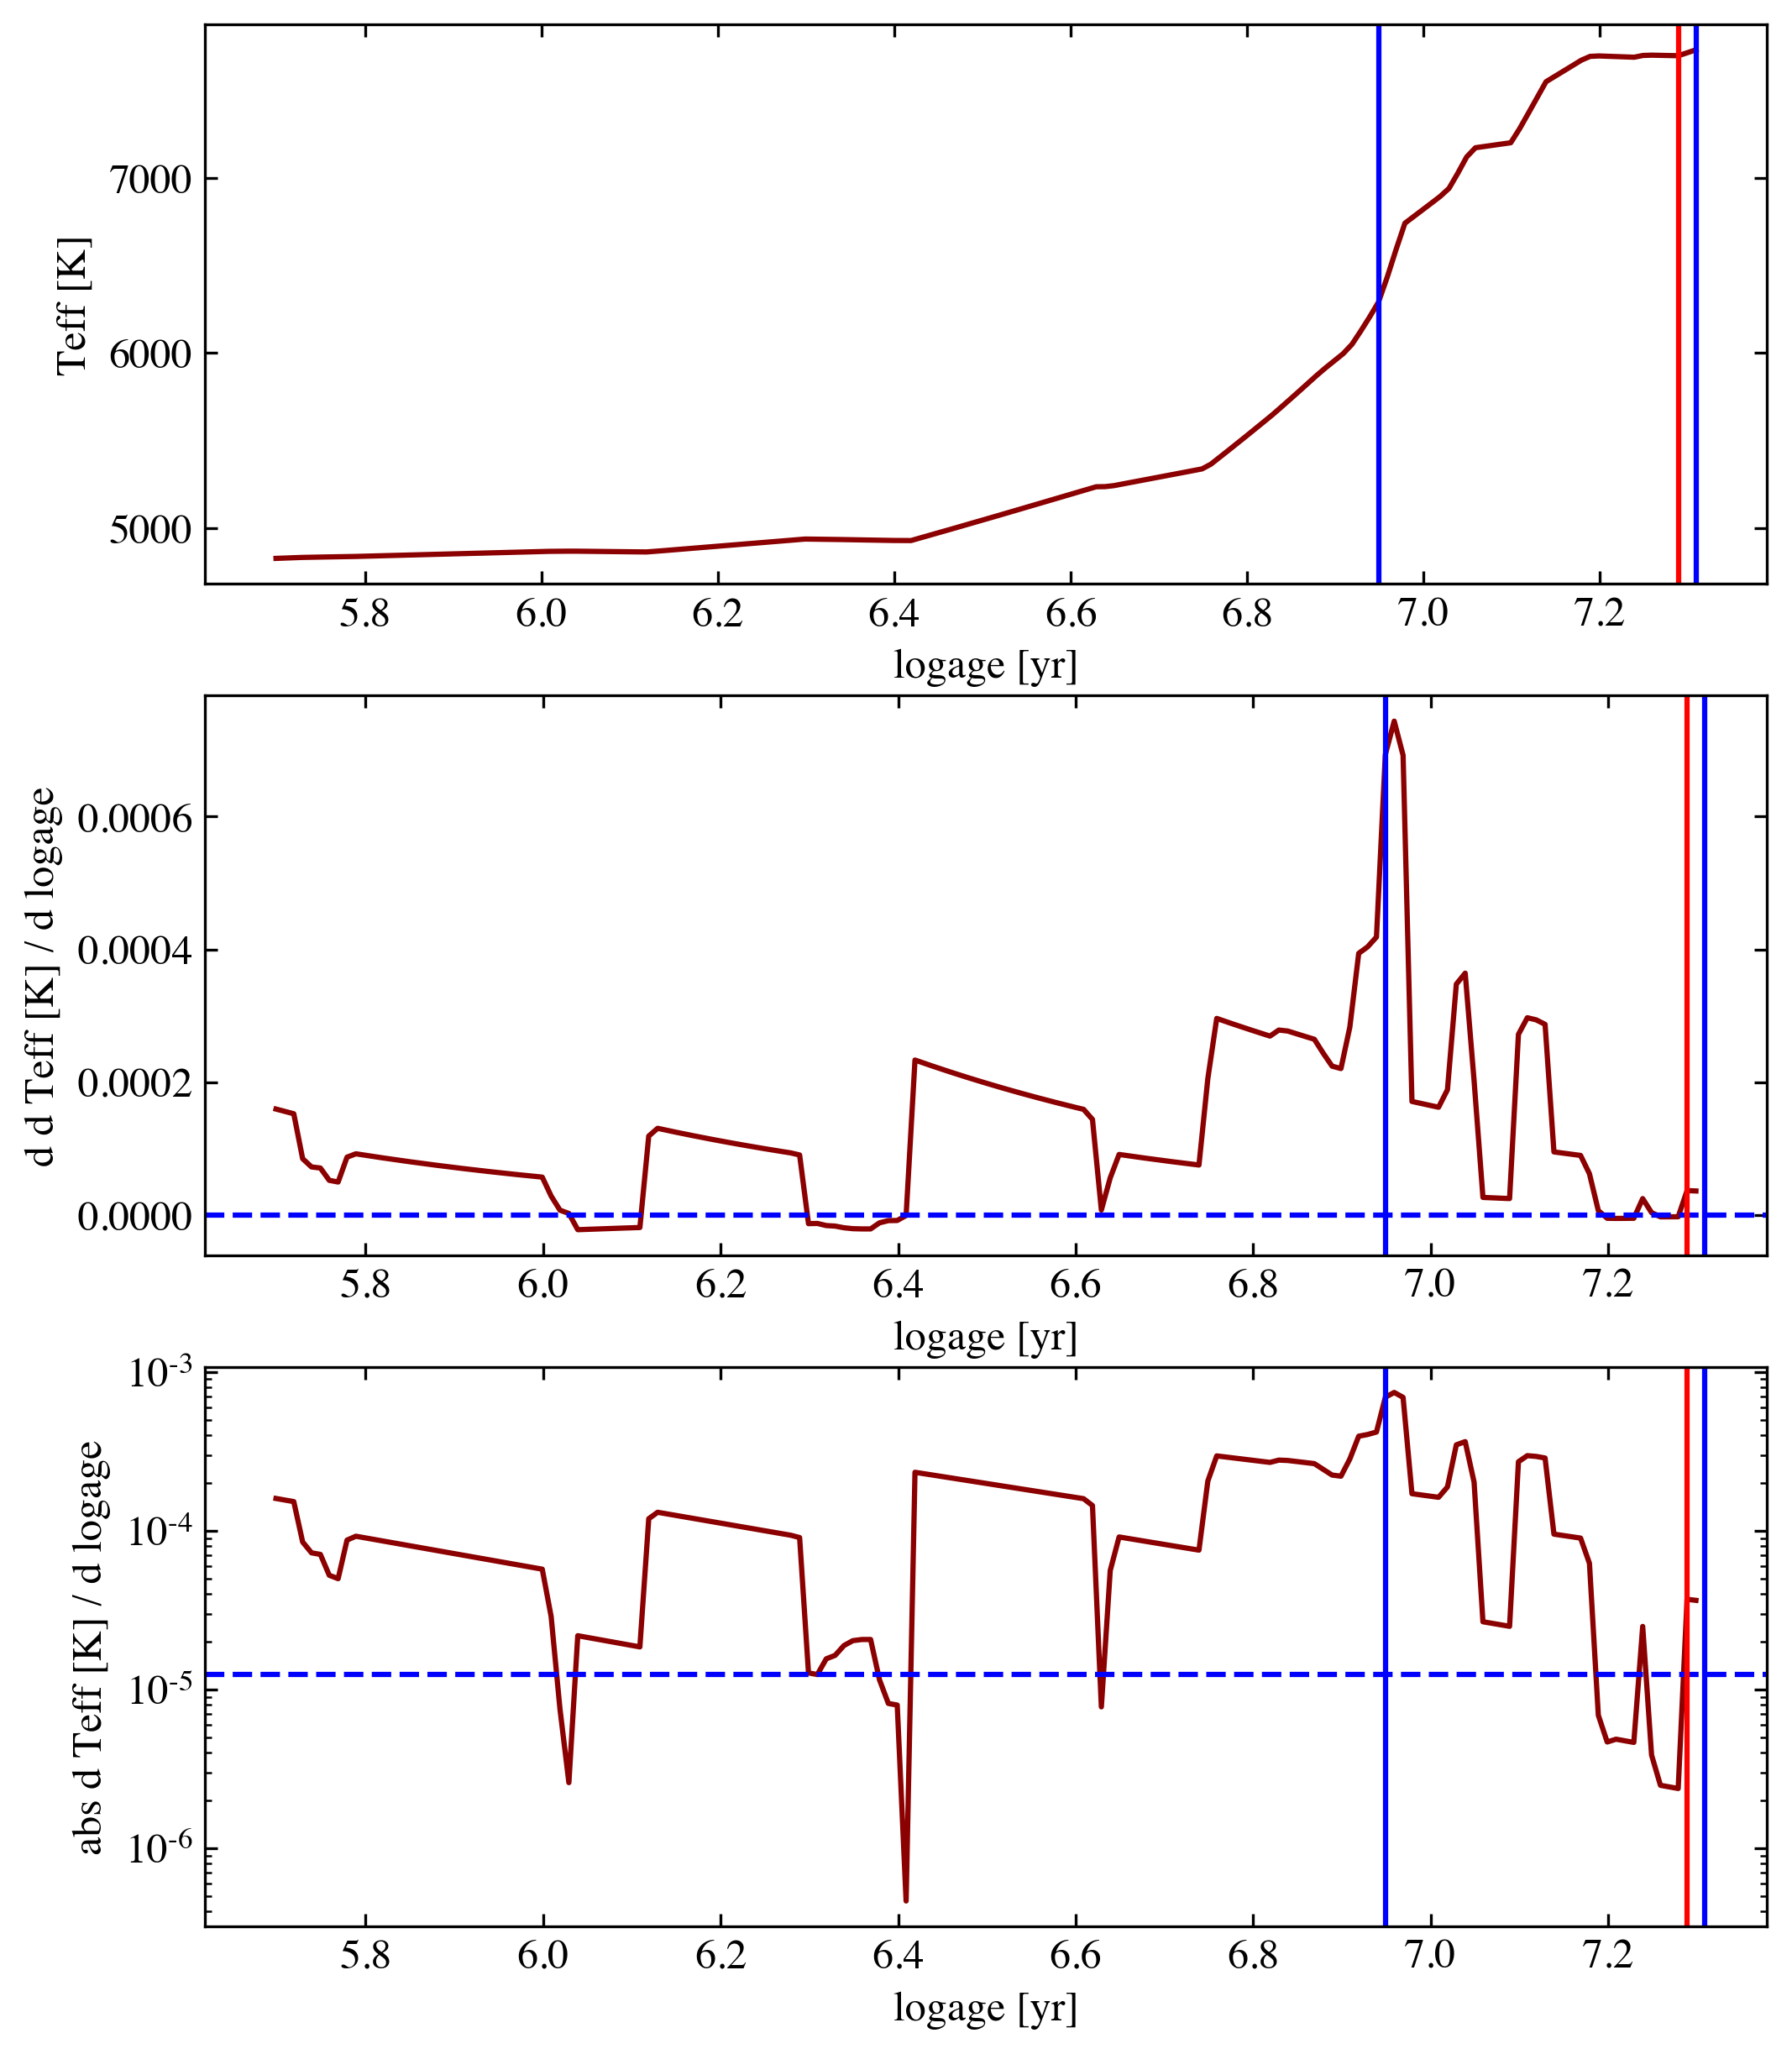

In [318]:
fig, axes = plt.subplots(3, 1, figsize=(8, 10))

log_age_max = log_age_max
idx_age_max = np.nanargmin(np.abs(isochrone.log_age - log_age_max))

teff_iso = 10**isochrone.logtlogl[:idx_age_max, :, 0]  # Teff
lum_iso = 10**isochrone.logtlogl[:idx_age_max, :, 1]   # L/Lo
mass = mass # solar masses
idx_mass = np.nanargmin(np.abs(isochrone.masses - mass))  # Find closest mass

ax = axes[0]
ax.plot(isochrone.log_age[:idx_age_max], teff_iso[:idx_age_max, idx_mass], '-', label=f'{mass:.1f} Msun', color='darkred')

ax.set_xlabel('logage [yr]')
ax.set_ylabel('Teff [K]')
# ax.set_ylabel('Luminosity [Lsolar]')

# ax.set_yscale('log')

dteff_dage = np.diff(teff_iso[:idx_age_max, idx_mass])/np.diff(10**isochrone.log_age[:idx_age_max])

ax = axes[1]
ax.plot(isochrone.log_age[:idx_age_max-1], dteff_dage, '-', label=f'{mass:.1f} Msun', color='darkred')

ax.axhline(0.0, linestyle='--', color='blue')

ax.set_xlabel('logage [yr]')
ax.set_ylabel('d d Teff [K] / d logage')
# ax.set_ylabel('Luminosity [Lsolar]')

# ax.set_ylim(-2.0, 2.0)

# ax.set_yscale('log')

ax = axes[2]
ax.plot(isochrone.log_age[:idx_age_max-1], np.abs(np.diff(teff_iso[:idx_age_max, idx_mass])/np.diff(10**isochrone.log_age[:idx_age_max])), '-', label=f'{mass:.1f} Msun', color='darkred')

percentile_10 = np.percentile(np.abs(dteff_dage), 10)

ax.axhline(percentile_10, linestyle='--', color='blue')

ax.set_xlabel('logage [yr]')
ax.set_ylabel('abs d Teff [K] / d logage')
# ax.set_ylabel('Luminosity [Lsolar]')

ax.set_yscale('log')
# ax.set_ylim(1e-1, )

for ax in axes:    
    # ax.axvline(isochrone.log_age[zams_idx_p], linestyle='-', color='magenta')
    ax.axvline(isochrone.log_age[idx_j], linestyle='-', color='blue')
    ax.axvline(isochrone.log_age[idx_j2], linestyle='-', color='blue')
    ax.axvline(isochrone.log_age[zams_idx_t], linestyle='-', color='red')
    # ax.axvline(isochrone.log_age[idx_j2+idx_j3], linestyle='-', color='magenta')

plt.show()

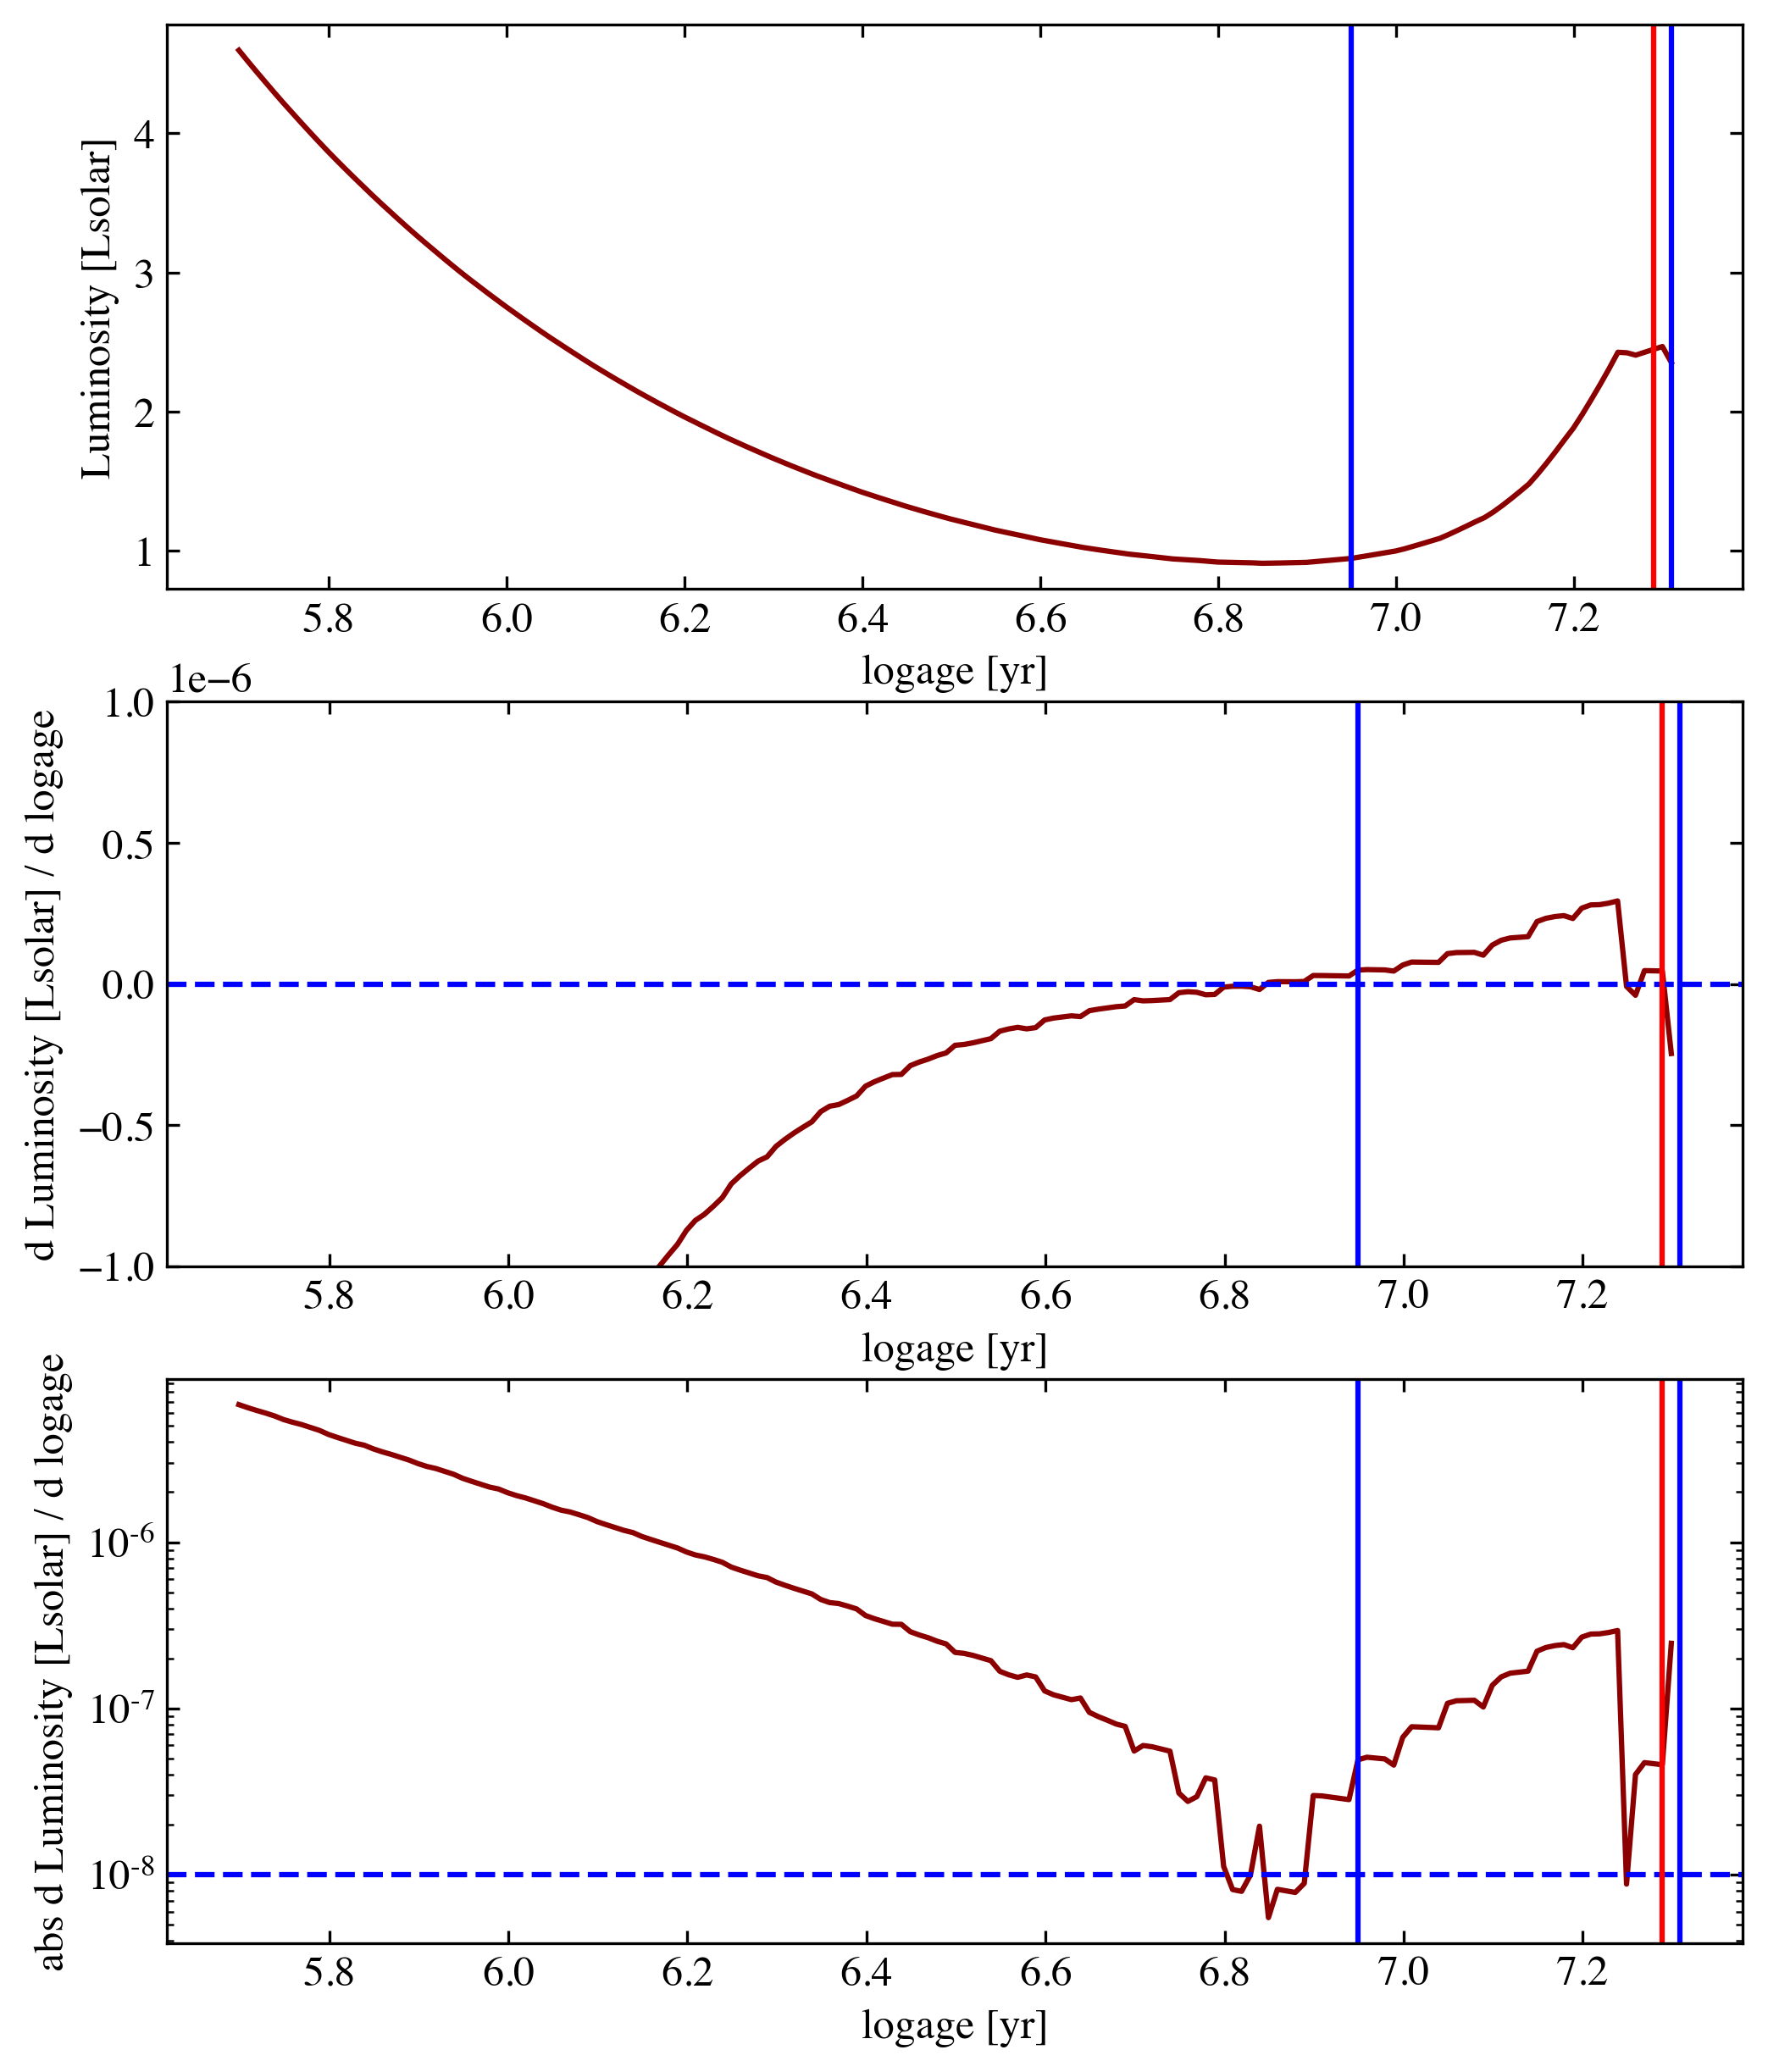

In [319]:
fig, axes = plt.subplots(3, 1, figsize=(8, 10))

log_age_max = log_age_max
idx_age_max = np.nanargmin(np.abs(isochrone.log_age - log_age_max))

teff_iso = 10**isochrone.logtlogl[:idx_age_max, :, 0]  # Teff
lum_iso = 10**isochrone.logtlogl[:idx_age_max, :, 1]   # L/Lo
mass = 1.2 # solar masses
idx_mass = np.nanargmin(np.abs(isochrone.masses - mass))  # Find closest mass

ax = axes[0]
ax.plot(isochrone.log_age[:idx_age_max], lum_iso[:idx_age_max, idx_mass], '-', label=f'{mass:.1f} Msun', color='darkred')

ax.set_xlabel('logage [yr]')
# ax.set_ylabel('Teff [K]')
ax.set_ylabel('Luminosity [Lsolar]')

# ax.set_yscale('log')

dlum_dage = np.diff(lum_iso[:idx_age_max, idx_mass])/np.diff(10**isochrone.log_age[:idx_age_max])

ax = axes[1]
ax.plot(isochrone.log_age[:idx_age_max-1], dlum_dage, '-', label=f'{mass:.1f} Msun', color='darkred')

ax.axhline(0.0, linestyle='--', color='blue')

ax.set_xlabel('logage [yr]')
# ax.set_ylabel('d Teff [K]')
ax.set_ylabel('d Luminosity [Lsolar] / d logage')

ax.set_ylim(-1e-6, 1e-6)

# ax.set_yscale('log')

ax = axes[2]
ax.plot(isochrone.log_age[:idx_age_max-1], np.abs(np.diff(lum_iso[:idx_age_max, idx_mass])/np.diff(10**isochrone.log_age[:idx_age_max])), '-', label=f'{mass:.1f} Msun', color='darkred')

percentile_10 = np.percentile(np.abs(dlum_dage), 5)

ax.axhline(percentile_10, linestyle='--', color='blue')

ax.set_xlabel('logage [yr]')
# ax.set_ylabel('d Teff [K] / d logage')
ax.set_ylabel('abs d Luminosity [Lsolar] / d logage')

ax.set_yscale('log')
# ax.set_ylim(1e-2, )

for ax in axes:
    # ax.axvline(isochrone.log_age[zams_idx_p], linestyle='-', color='magenta')
    ax.axvline(isochrone.log_age[idx_j], linestyle='-', color='blue')
    ax.axvline(isochrone.log_age[idx_j2], linestyle='-', color='blue')
    ax.axvline(isochrone.log_age[zams_idx_t], linestyle='-', color='red')
    # ax.axvline(isochrone.log_age[idx_j2+idx_j3], linestyle='-', color='magenta')

plt.show()